# Part 1: Demosaicing

##Malvar filters

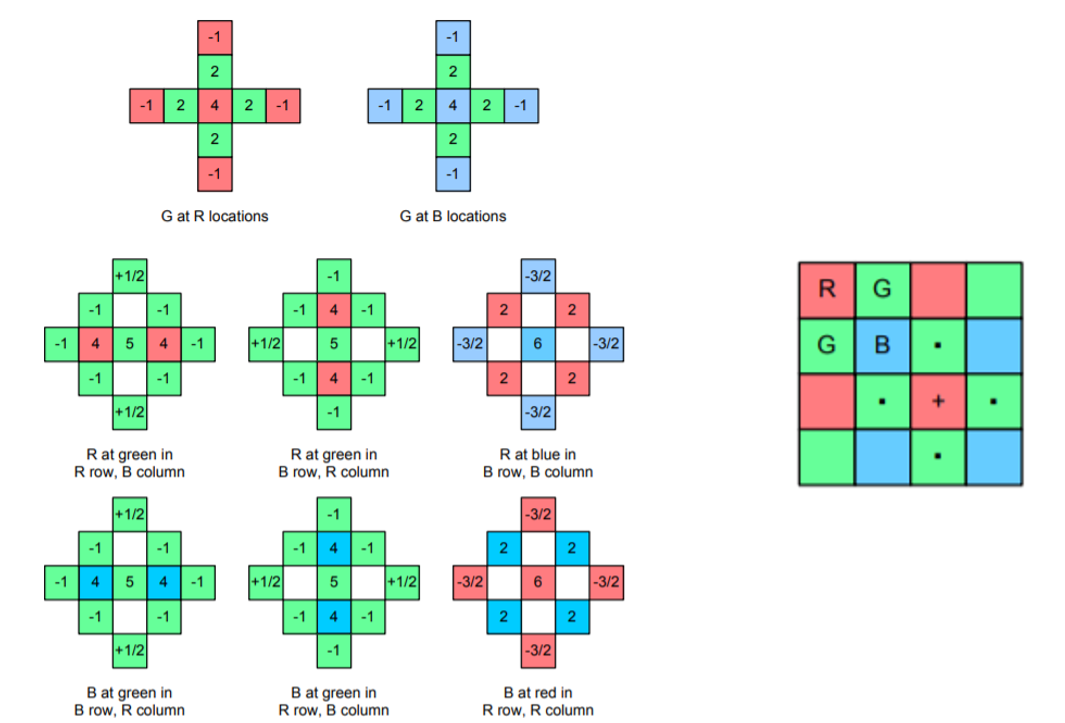

In [ ]:
import os
import glob
import cv2 as cv
import numpy as np
import torch
#Pytorch has been used for filter implementation and tensor operations  
import torch.nn as nn
from google.colab.patches import cv2_imshow

#--------------------------Malvar filters-----------------------
GR_GB = torch.tensor(
    [[0, 0, -1, 0, 0],
     [0, 0, 2, 0, 0],
     [-1, 2, 4, 2, -1],
     [0, 0, 2, 0, 0],
     [0, 0, -1, 0, 0]], dtype=torch.float64) / 8  

RG_RrBc_BG_BrRc = torch.tensor(
    [[0, 0, 0.5, 0, 0],
     [0, -1, 0, -1, 0],
     [-1, 4, 5, 4, - 1],
     [0, -1, 0, -1, 0],
     [0, 0, 0.5, 0, 0]], dtype=torch.float64) / 8  

RG_BrRc_BG_RrBc = torch.transpose(RG_RrBc_BG_BrRc,0,1)

RB_BR = torch.tensor(
    [[0, 0, -1.5, 0, 0],
     [0, 2, 0, 2, 0],
     [-1.5, 0, 6, 0, -1.5],
     [0, 2, 0, 2, 0],
     [0, 0, -1.5, 0, 0]], dtype=torch.float64) / 8
#----------------------------------------------------------------

In [ ]:
# Function to apply Malvar filters 
def conv_dconv(inp, flt, wt, pad=False):
    #2,1,2,1 1,0,0,0
    #1,2,1,2 0,0,0,1
    #2,1,1,2 0,0,1,0
    #1,2,2,1 0,1,0,0
    if pad == 0:
        pad_inp = (0,0,0,0)
    else:
        if wt[0,0].item() == 1:
            pad_inp = (2,1,2,1)
        elif wt[1,1].item() == 1:
            pad_inp = (1,2,1,2)
        elif wt[1,0].item() == 1:
            pad_inp = (2,1,1,2)
        elif wt[0,1].item() ==1:
            pad_inp = (1,2,2,1)

    flt = flt.repeat(1,1,1,1)
    wt = wt.repeat(1,1,1,1)
        
    inp = nn.functional.pad(inp, pad_inp)
    out = nn.functional.conv2d(inp, flt, stride = 2)
    out = nn.functional.conv_transpose2d(out, wt, stride=2)
    return out

# PSNR ratio

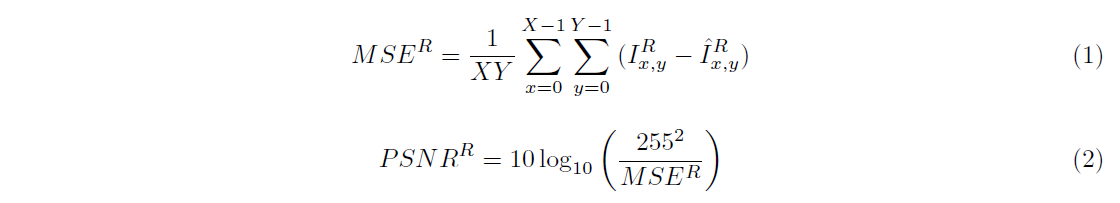

In [ ]:
#Function to calculate PSNR ratio

def psnr(img, imgd):
    mse = np.sum(img - imgd)**2/img.shape[0]*img.shape[1]
    return 10*np.log10(255*255/mse)

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive


In [ ]:
def demosaic_rgb(img):
  inp = torch.tensor(img).permute(2,0,1).unsqueeze(0).type(torch.float64)

  r_ch = inp[:,0,:,:].unsqueeze(0)
  g_ch = inp[:,1,:,:].unsqueeze(0)
  b_ch = inp[:,2,:,:].unsqueeze(0) 
      
  #-------------------G and B @ R---------------------------------

  wt = torch.tensor([[1,0],[0,0]], dtype=torch.float64)
  R_R = conv_dconv(r_ch, wt, wt, pad=False)
  G_R = conv_dconv(g_ch, GR_GB, wt, pad=True)
  B_R = conv_dconv(b_ch, RB_BR, wt, pad=True)

  #-------------------G and R @ B---------------------------------
  wt = torch.tensor([[0,0],[0,1]], dtype=torch.float64)
  R_B = conv_dconv(r_ch, RB_BR, wt, pad=True)
  G_B = conv_dconv(g_ch, GR_GB, wt, pad=True)
  B_B = conv_dconv(b_ch, wt, wt, pad=False)

  #-------------------R and B @ G---------------------------------
  #-------------------R and B @ B row and R column----------------
  wt = torch.tensor([[0,0],[1,0]], dtype=torch.float64)
  R_G_BrRc = conv_dconv(r_ch, RG_BrRc_BG_RrBc, wt, pad=True)
  G_G_BrRc = conv_dconv(g_ch, wt, wt, pad=False)
  B_G_BrRc = conv_dconv(b_ch, RG_RrBc_BG_BrRc, wt, pad=True)

  #---------------------------------------------------------------
  #-------------------R and B @ G---------------------------------
  #-------------------R and B @ R row and B column----------------
  wt = torch.tensor([[0,1],[0,0]], dtype=torch.float64)
  R_G = conv_dconv(r_ch, RG_RrBc_BG_BrRc, wt, pad=True)
  G_G = conv_dconv(g_ch, wt, wt, pad=False)
  B_G = conv_dconv(b_ch, RG_BrRc_BG_RrBc, wt, pad=True)

  #---------------------------------------------------------------

  R = R_R + R_B + R_G_BrRc + R_G
  G = G_R + G_B + G_G_BrRc + G_G
  B = B_R + B_B +  B_G_BrRc + B_G
  return [R,G,B]

---------PSNR---------
PSNR_R: -51.67,         PSNR_G: -47.73,         PSNR_B: -50.08
----------------------


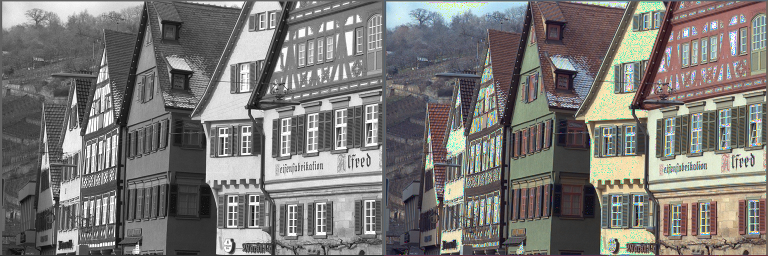

 
---------PSNR---------
PSNR_R: -49.22,         PSNR_G: -42.58,         PSNR_B: -44.00
----------------------


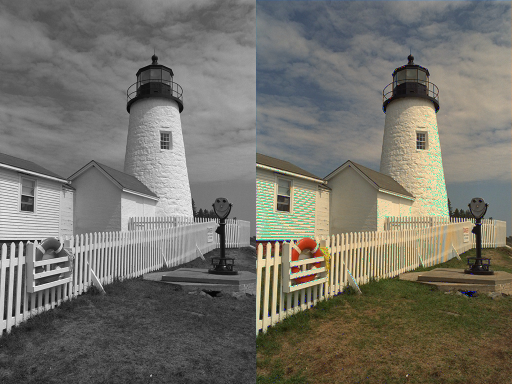

 
---------PSNR---------
PSNR_R: -46.74,         PSNR_G: -45.71,         PSNR_B: -44.79
----------------------


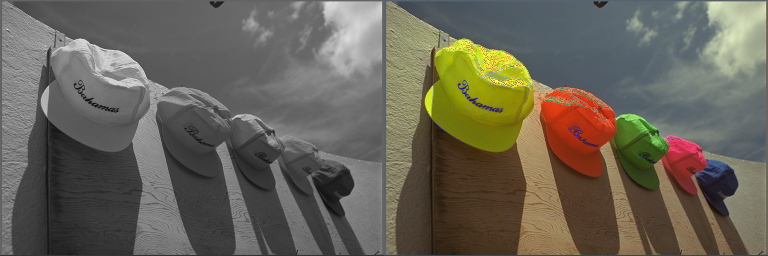

 
---------PSNR---------
PSNR_R: -51.69,         PSNR_G: -40.34,         PSNR_B: -47.82
----------------------


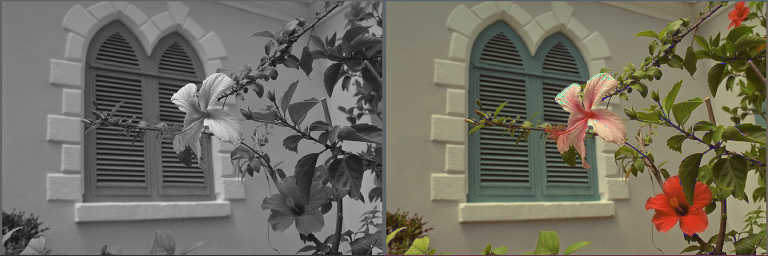

In [ ]:

PATH = os.getcwd()
if os.path.isdir(PATH):
    fname = glob.glob(PATH + '/data/demosaicing/*/*.jpg')
    fname_org = glob.glob(PATH + '/data/demosaicing/*/*.png')
    
    for i in range(len(fname)):
        img_org = cv.imread(fname_org[i])
        img = cv.imread(fname[i])
         
        R,G,B = demosaic_rgb(img)
        imgd = torch.cat((R,G,B),1).squeeze(0).squeeze(0).permute(1,2,0)
        imgt = imgd.byte().numpy()

        # concatanate image Horizontally
        Hori = np.concatenate((img, imgt), axis=1)
        # Saving demosiced image after concatenating with original image
        cv.imwrite(os.path.splitext(fname[i])[0]+'demosaic.bmp', Hori)
        
        print("---------PSNR---------")
        print(f'PSNR_R: {psnr(img_org[:,:,0], imgd[:,:,0].numpy()):.2f}, \
        PSNR_G: {psnr(img_org[:,:,1], imgd[:,:,1].numpy()):.2f}, \
        PSNR_B: {psnr(img_org[:,:,2], imgd[:,:,2].numpy()):.2f}')

        print("----------------------")
        half = cv.resize(Hori, (0, 0), fx = 0.5, fy = 0.5)
        #output image resized for display in notebook
        #demosaiced imaged stored with original size
        cv2_imshow(half)
        print(" ")

# Part 2 of Assignment

# Night Vision

### Gamma correction and HIstogram equalization

In [ ]:
def gammaCorrection(src, gamma):
    invGamma = 1 / gamma
    table = [((i / 255) ** invGamma) * 255 for i in range(256)]
    table = np.array(table, np.uint8)
    return cv.LUT(src, table)

def histeq(src):   
    img_yuv = cv.cvtColor(src, cv.COLOR_BGR2YUV)
    # equalize the histogram of the Y channel
    img_yuv[:,:,0] = cv.equalizeHist(img_yuv[:,:,0])
    # convert the YUV image back to RGB format
    img_output = cv.cvtColor(img_yuv, cv.COLOR_YUV2BGR)
    return img_output

Original Image | Gamma Correction | Histogram Equalization on Y Channel 


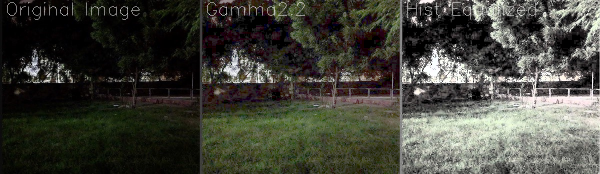

 
Original Image | Gamma Correction | Histogram Equalization on Y Channel 


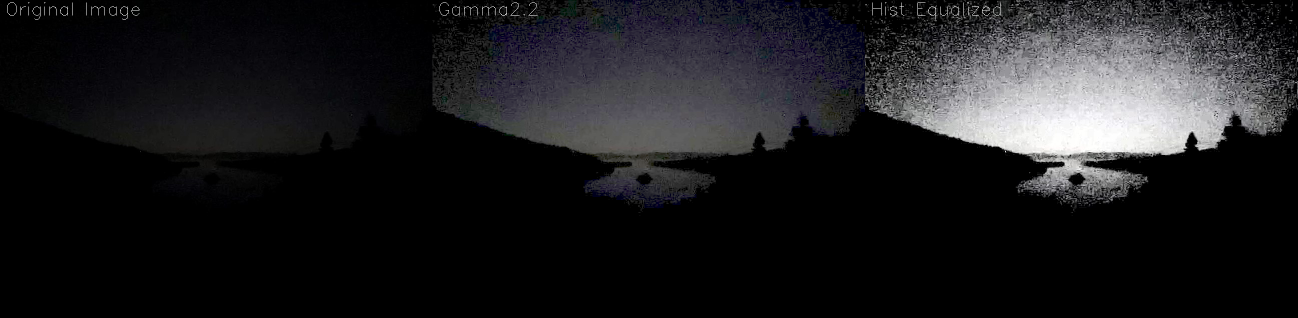

 
Original Image | Gamma Correction | Histogram Equalization on Y Channel 


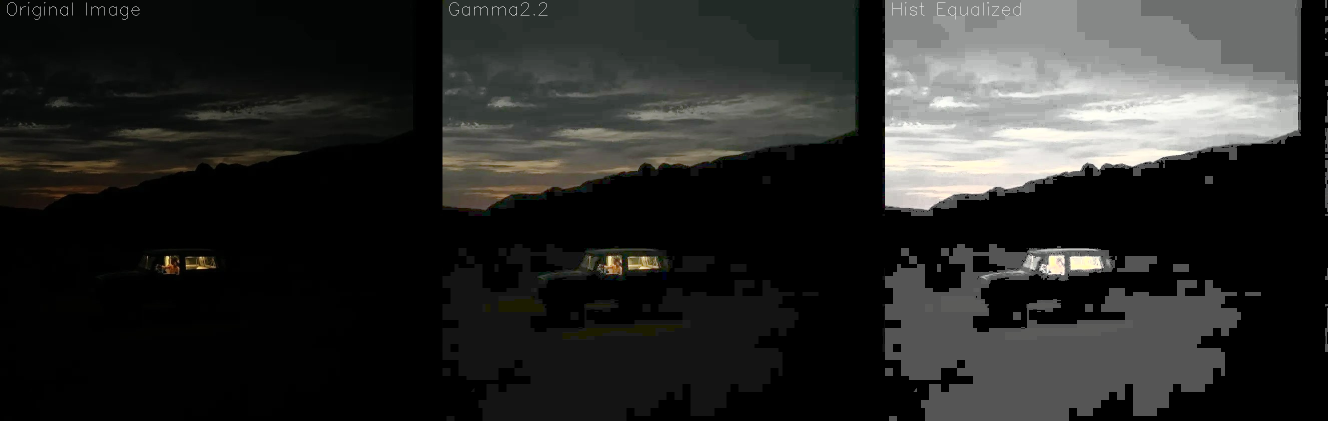

 
Original Image | Gamma Correction | Histogram Equalization on Y Channel 


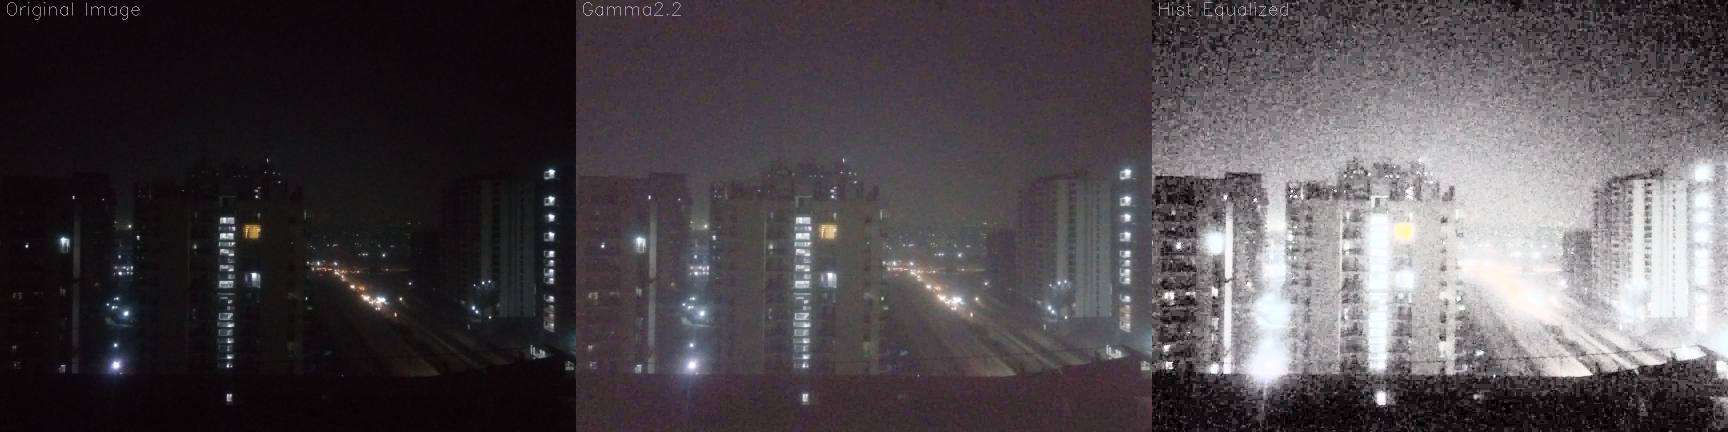

In [ ]:
if os.path.isdir(PATH):
    fname = glob.glob(PATH + '/data/night/*/*_off.jpg')
    
    for i in range(len(fname)):
        #img_org = cv.imread(fname_org[i])
        img = cv.imread(fname[i])
        gamma = 2.2
        # Getting gamma coorected image
        gammaImg = gammaCorrection(img, gamma)
        # Display gamma value on corrected image
        cv.putText(gammaImg, "Gamma"+str(gamma), (10,30), cv.FONT_HERSHEY_SIMPLEX, 1.2, (255,255,255))

        #Histogram equalization
        histImg = histeq(img)
        cv.putText(histImg, "Hist Equalized", (10,30), cv.FONT_HERSHEY_SIMPLEX, 1.2, (255,255,255))
        
        cv.putText(img, "Original Image", (10,30), cv.FONT_HERSHEY_SIMPLEX, 1.2, (255,255,255))
        Hori = np.concatenate((img, gammaImg, histImg), axis=1)
        half = cv.resize(Hori, (0, 0), fx = 0.5, fy = 0.5)
        print("Original Image | Gamma Correction | Histogram Equalization on Y Channel ")
        cv2_imshow( half)
        print(" ")

### Foggy images correction

Original Image | Histogram Equalization Correction | CLAHE Image


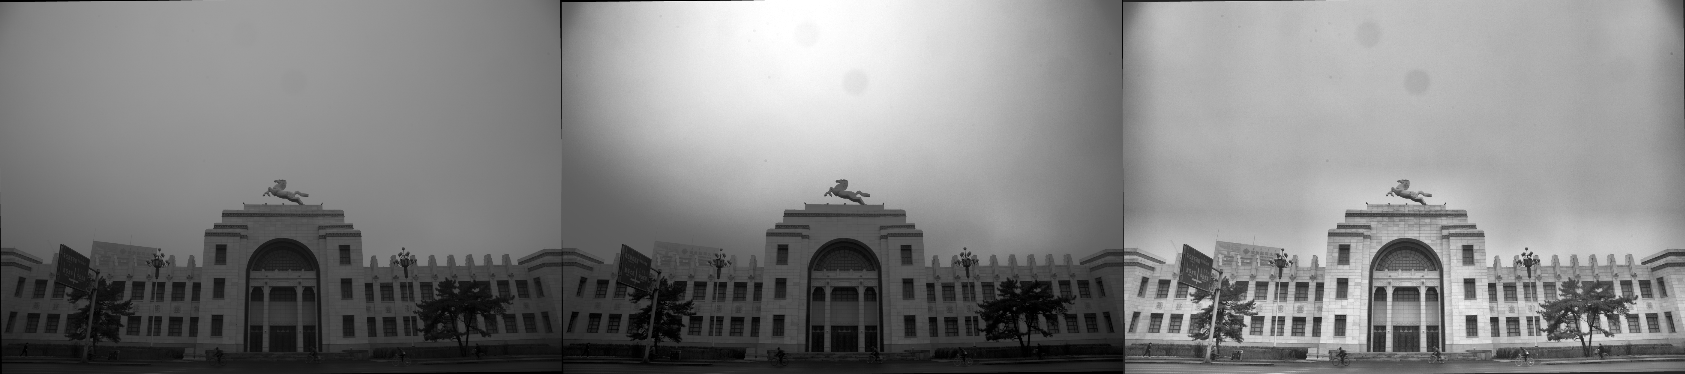

 
Original Image | Histogram Equalization Correction | CLAHE Image


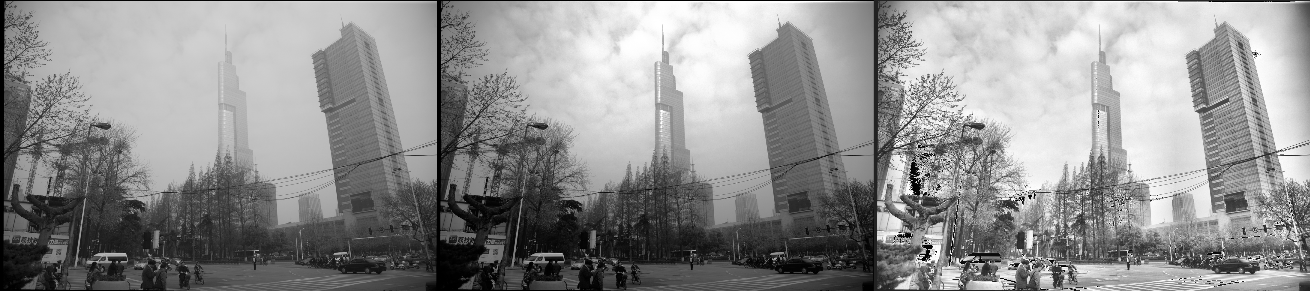

 
Original Image | Histogram Equalization Correction | CLAHE Image


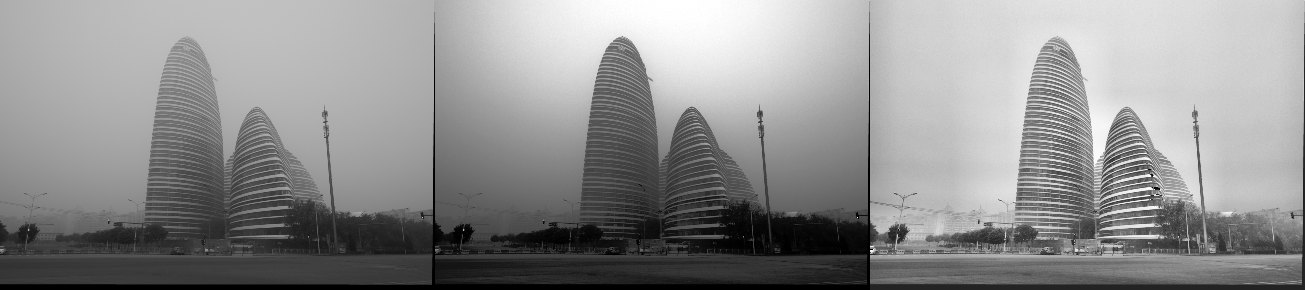

In [36]:
if os.path.isdir(PATH):
    fname = glob.glob(PATH + '/data/fog/*/foggy.png')
    
    for i in range(len(fname)):
        #img_org = cv.imread(fname_org[i])
        img = cv.imread(fname[i])

        image_bw = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        
        # The declaration of CLAHE
        # clipLimit -> Threshold for contrast limiting
        clahe = cv.createCLAHE(clipLimit = 4)
        final_img = clahe.apply(image_bw) + 30
        
        # Ordinary thresholding the same image
        ordinary_img = cv.equalizeHist(image_bw)

        Hori = np.concatenate((image_bw, ordinary_img, final_img), axis=1)
        half = cv.resize(Hori, (0, 0), fx = 0.3, fy = 0.3)
        print("Original Image | Histogram Equalization Correction | CLAHE Image")
        cv2_imshow( half)
        print(" ")

# Video sequence enhancement

In [ ]:
if os.path.isdir(PATH):
    fname = glob.glob(PATH + '/data/video/*.mpg')
    cap = cv.VideoCapture(fname[0])
    if cap.isOpened():
        h = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))
        w = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
        
        fps = int(cap.get(cv.CAP_PROP_FPS))
        n_frames = int(cap.get(cv.CAP_PROP_FRAME_COUNT))
    cap.release()
    fourcc = cv.VideoWriter_fourcc(*'mp4v') 
    video = cv.VideoWriter('video.avi', fourcc, fps, (w, h))

    cap = cv.VideoCapture(fname[0])
    while cap.isOpened():
        index = int(cap.get(cv.CAP_PROP_POS_FRAMES))
        #print("Frame # being read : ", index)
        
        success, img = cap.read()
        if not success:
            print("Can't receive frame (stream end?). Exiting ...")
            break
        gammaImg = gammaCorrection(img, gamma)
        cv.imwrite(r'./data/video/output/'+'%05d'%index+'.jpg', gammaImg)
    cap.release()

Can't receive frame (stream end?). Exiting ...


In [ ]:
for i in range(index):
  img = cv.imread(r'./data/video/output/'+'%05d'%i+'.jpg')
  video.write(img)    

cv.destroyAllWindows()
video.release()